# **Import, cleaning and preparation of CDSS data from Rwanda for spatio-temporal clustering**

Please note the usage of the following abbrevations:
- RW = Rw = Rwanda
- hf = healthcare facility
- ...

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys
!{sys.executable} -m pip install openpyxl
!{sys.executable} -m pip install thefuzz
!{sys.executable} -m pip install pyshp


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import data and get overview

In [4]:
# import raw data
raw_rw_data = pd.read_csv("data/rwanda/13-02-2023-export_flat/answers.csv", warn_bad_lines=True, error_bad_lines=False)

b'Skipping line 9087: expected 2025 fields, saw 2028\n'


# Data cleaning

In [5]:
rw_data = raw_rw_data.copy()

## Mandatory cleaning according to domain experts

#### cleaning is done based on this R code:
----
    ## Filter to keep only non-test health facilities
    med_cases <- med_cases %>%  filter(health_facility_group_id == 128 | health_facility_group_id == 129 | health_facility_group_id == 132 |
                            health_facility_group_id == 133 | health_facility_group_id == 140 | health_facility_group_id == 126 |
                            health_facility_group_id == 130 | health_facility_group_id == 131 | health_facility_group_id == 138 |
                            health_facility_group_id == 171 | health_facility_group_id == 106 | health_facility_group_id == 108 |
                            health_facility_group_id == 117 | health_facility_group_id == 135 | health_facility_group_id == 137 |
                            health_facility_group_id == 103 | health_facility_group_id == 114 | health_facility_group_id == 115 |
                            health_facility_group_id == 116 | health_facility_group_id == 125 | health_facility_group_id == 104 |
                            health_facility_group_id == 105 | health_facility_group_id == 109 | health_facility_group_id == 118 |
                            health_facility_group_id == 120 | health_facility_group_id == 122 | health_facility_group_id == 107 |
                            health_facility_group_id == 110 | health_facility_group_id == 111 | health_facility_group_id == 112 |
                            health_facility_group_id == 119 | health_facility_group_id == 121)
    ## Create study arm label
    med_cases$arm <- med_cases$health_facility_group_id
    med_cases$arm[med_cases$health_facility_group_id %in% c(128,129,132,133,140,106,108,117,135,137,104,105,109,118,120,122)] <- "Control"
    med_cases$arm[med_cases$health_facility_group_id %in% c(126,130,131,138,171,103,114,115,116,125,107,110,111,112,119,121)] <- "Intervention"
    ## Create group id label
    med_cases$group <- med_cases$health_facility_group_id
    med_cases$group[med_cases$health_facility_group_id %in% c(128,129,132,133,140,126,130,131,138,171)] <- "Group 1"
    med_cases$group[med_cases$health_facility_group_id %in% c(106,108,117,135,137,103,114,115,116,125)] <- "Group 2"
    med_cases$group[med_cases$health_facility_group_id %in% c(104,105,109,118,120,122,107,110,111,112,119,121)] <- "Group 3"
    ## Drop test cases, etc. 
    med_cases <- med_cases %>% filter(med_cases$medical_case_duplicate == 0 &
                                    med_cases$medical_case_is_drop == 0)
    ## Group 1 - intervention arm (December 2021 to present)
    med_cases_grp1_i <- med_cases %>% filter(
                        medical_case_consultation_date >= "2021-12-01" &
                        group == "Group 1" & arm == "Intervention")
    ## Group 1 - control arm (June 2022 to present)
    med_cases_grp1_c <- med_cases %>% filter(
                        medical_case_consultation_date >= "2022-06-01" &
                        group == "Group 1" & arm == "Control")
    ## Group 2 - intervention arm (March 2022 to present)
    med_cases_grp2_i <- med_cases %>% filter(
    medical_case_consultation_date >= "2022-03-01" &
        group == "Group 2" & arm == "Intervention")
    ## Group 2 - control arm (September 2022 to present)
    med_cases_grp2_c <- med_cases %>% filter(
    medical_case_consultation_date >= "2022-09-01" &
        group == "Group 2" & arm == "Control")
    ## Group 3 - intervention arm (June 2022 to present)
    med_cases_grp3_i <- med_cases %>% filter(
    medical_case_consultation_date >= "2022-06-01" &
        group == "Group 3" & arm == "Intervention")
    ## Group 3 - control arm (December 2022 to present)
    med_cases_grp3_c <- med_cases %>% filter(
    medical_case_consultation_date >= "2022-12-01" &
        group == "Group 3" & arm == "Control")
    ## Merge the datasets
    med_cases <- rbind(med_cases_grp1_i,med_cases_grp1_c,
                    med_cases_grp2_i, med_cases_grp2_c,
                    med_cases_grp3_i, med_cases_grp3_c)


In [6]:
# Filter to keep only non-test health facilities
string_of_filter_code_in_r = "filter(health_facility_group_id == 128 | health_facility_group_id == 129 | health_facility_group_id == 132 | health_facility_group_id == 133 | health_facility_group_id == 140 | health_facility_group_id == 126 |health_facility_group_id == 130 | health_facility_group_id == 131 | health_facility_group_id == 138 |health_facility_group_id == 171 | health_facility_group_id == 106 | health_facility_group_id == 108 |health_facility_group_id == 117 | health_facility_group_id == 135 | health_facility_group_id == 137 |health_facility_group_id == 103 | health_facility_group_id == 114 | health_facility_group_id == 115 |health_facility_group_id == 116 | health_facility_group_id == 125 | health_facility_group_id == 104 |health_facility_group_id == 105 | health_facility_group_id == 109 | health_facility_group_id == 118 |health_facility_group_id == 120 | health_facility_group_id == 122 | health_facility_group_id == 107 |health_facility_group_id == 110 | health_facility_group_id == 111 | health_facility_group_id == 112 |health_facility_group_id == 119 | health_facility_group_id == 121)"
group_id_non_test_hfs = [int(s) for s in string_of_filter_code_in_r.split() if s.isdigit()] #refers to "health_facility_group_id"
rw_data = rw_data[rw_data["health_facility_group_id"].isin(group_id_non_test_hfs)]

In [7]:
print("remaining hf in dataset (hf_group_id):", np.sort(rw_data["health_facility_group_id"].unique()))

remaining hf in dataset (hf_group_id): [103 104 105 106 107 108 109 110 111 112 114 115 116 117 118 119 120 122
 125 126 128 129 130 131 132 133 135 137 138 140 171]


In [8]:
# Drop test cases, etc. 
rw_data = rw_data.loc[(rw_data["medical_case_duplicate"] == 0) & (rw_data["medical_case_is_drop"] == 0)]

### Get only consultations part of the intervention period of each group (Group 1 - 3)
![Red are the relevant consultations](data/rwanda/graph_relevant_consultations.JPG)

In [9]:
# Create study arm label
control_hfs = [128,129,132,133,140,106,108,117,135,137,104,105,109,118,120,122]
intervention_hfs = [126,130,131,138,171,103,114,115,116,125,107,110,111,112,119,121]

rw_data["arm"] = ["control" if group_id in control_hfs else "intervention" for group_id in rw_data["health_facility_group_id"]]

In [10]:
# Create group id label
group1_hfs = [128,129,132,133,140,126,130,131,138,171]
group2_hfs = [106,108,117,135,137,103,114,115,116,125]
group3_hfs = [104,105,109,118,120,122,107,110,111,112,119,121]

rw_data["group"] = [1 if group_id in group1_hfs else 2 if group_id in group2_hfs else 3 for group_id in rw_data["health_facility_group_id"]]

In [11]:
# filter for consultation part of the intervention period
rw_data["intervention_period_start"] = "2021-12-01" # intervetnion period start for group 1 of intervention arm
rw_data.loc[(rw_data["arm"] == "intervention") & (rw_data["group"] == 2), "intervention_period_start"] = "2022-03-01"
rw_data.loc[(rw_data["arm"] == "intervention") & (rw_data["group"] == 3), "intervention_period_start"] = "2022-06-01"
rw_data.loc[(rw_data["arm"] == "control") & (rw_data["group"] == 1), "intervention_period_start"] = "2022-06-01"
rw_data.loc[(rw_data["arm"] == "control") & (rw_data["group"] == 2), "intervention_period_start"] = "2022-09-01"
rw_data.loc[(rw_data["arm"] == "control") & (rw_data["group"] == 3),"intervention_period_start"] = "2022-12-01"

rw_data = rw_data[rw_data["intervention_period_start"] <= rw_data["medical_case_consultation_date"]]

### Correct gps coordinates of hf

GPS coordinates in columns: "health_facility_longitude", "health_facility_latitude" are wrong and need to be corrected using a excel file provided by domain experts.

In [12]:
import re #import regex
hf_data = pd.read_excel("data/rwanda/hf/Health Facility Selection_v3.xlsx", sheet_name="Selected HFs")[["Facity Name", "Longitude", "Latitude",]]
hf_data[["Longitude", "Latitude"]].columns = ["hf_longitude", "hf_latitude"] # TODO correct

# clean hf name for join
rw_data['health_facility_name'] = [re.sub(r'\([^)]*\)', '', hf.replace("RW", "")).replace("  ", " ") for hf in rw_data["health_facility_name"]] 
rw_data = rw_data.merge(hf_data, how="left", left_on='health_facility_name', right_on='Facity Name')

In [13]:
rw_data[["Longitude", "Latitude"]] # TODO nvestgate

Longitude  Latitude
0            NaN       NaN
1            NaN       NaN
2            NaN       NaN
3            NaN       NaN
4            NaN       NaN
...          ...       ...
48102        NaN       NaN
48103        NaN       NaN
48104        NaN       NaN
48105        NaN       NaN
48106        NaN       NaN

[48107 rows x 2 columns]

In [14]:
for e in rw_data.columns:
    if "longitude" in e.lower():
        print(e)

health_facility_longitude
Longitude


In [15]:
import plotly.express as px
fig = px.scatter_mapbox(rw_data, lon="Longitude", lat="Latitude", hover_name = 'health_facility_name',
                                hover_data = ['health_facility_name'],
                                center=dict(lon=30, lat=-1.9), zoom=7,
                                mapbox_style="stamen-terrain") #animation_frame='Date' for temporal dimension
fig.show()

### Clean column: "BD9 - Village (Umudugudu) - 8062" (= origin of patient)

Since the origin of a patient that seeked a consultation is inputted manually in the CDSS, diverse errors (e. g. spelling mistake, incomplete description etc.) need to be considered. Based on the experience of the domain experts, we agreed on the following data cleaning methodology to be the best:
1. drop consultations without record of patient's origin
2. normalise the inputted patient's origin
    - remove whitespaces
    - lowercase
    - remove coma (= making each value of the column a single string of village, cell, sector and district)
3. validate precision of the inputted patient's origin by comparing it to the village master list, a excel file provided by domain experts that contains all villages in Rwanda with correct description of the village using village, cell, sector and district as descriptive terms.
    - if the inputted patient's origin does not match one village in the master list, it will be replaced by the village from the master list which equals the closest (= fuzzy search).
    - if the inputted patient's origin is only one word and it does not match one village in the master list, it will be corrected based on a fuzzy search on the catchment area of the hf where the consultation was held.

In [16]:
# filter out consultations with patients whose origin is not known (=NaN)
print("number of consultations without record of patient's origin:", sum(rw_data["BD9 - Village (Umudugudu) - 8062"].isna()))
rw_data = rw_data.dropna(subset=["BD9 - Village (Umudugudu) - 8062"])

number of consultations without record of patient's origin: 0


In [17]:
# normalise village column (remove whitespace and lowercase everything)
rw_data["BD9 - Village (Umudugudu) - 8062"] =  rw_data["BD9 - Village (Umudugudu) - 8062"].str.replace(" ", "")
rw_data["BD9 - Village (Umudugudu) - 8062"] =  rw_data["BD9 - Village (Umudugudu) - 8062"].str.lower()

In [18]:
# import records of all rw villages in their complete description (provided by domain experts)
village_master = pd.read_excel("data/rwanda/village/Village_master_list.xlsx")

# only keep villages in districts rusizi and nyamasheke as these are the only considered districts of the current study (according to domain expert)
village_master = village_master.loc[(village_master["District_Name"] == "Rusizi") | (village_master["District_Name"] == "Nyamasheke")]

# normalise village description: lowercase everything
village_master = village_master.applymap(lambda s: s.lower() if type(s) == str else s)

#### Analysis of correctness of patient's origin as inputted in CDSS

In [19]:
v = rw_data.copy()

# count how many words were inputted in CDSS tool by clinician to describe patient's origin
v["count_desc_values"] = [ len(village.split(",")) for village in rw_data["BD9 - Village (Umudugudu) - 8062"]]

# how many consultations have how many descriptive terms for their respective patient's origin
v.groupby("count_desc_values")["medical_case_id"].count().reset_index(name="number_consultations")

count_desc_values  number_consultations
0                  1                   656
1                  2                    18
2                  3                    96
3                  4                 47318
4                  5                    19

In [20]:
# create one word for the village description as inputted in CDSS tool
v["village_one_word"] = rw_data["BD9 - Village (Umudugudu) - 8062"].str.replace(",", "")

# create one word for the village description in the village master list
village_master["village_one_word"] = village_master["Village_Name"] + village_master["Cell_Name"] + village_master["Sector_Name"] + village_master["District_Name"]

In [21]:
# merge rw data with village master list to identify the correctness of the inputted patient's origin
v = v.merge(village_master, on="village_one_word", how="left")

In [22]:
# get consultations with correctly inputted patient's origin
v_with_correct_village_desc = v[~v["Village_Name"].isna()]
print("Share of consultation with correct village description (in %):", v_with_correct_village_desc.shape[0]/v.shape[0]*100)

Share of consultation with correct village description (in %): 96.3996923524643


In [23]:
# get consultations with wrongly inputted patient's origin but with more than one descriptive term
v_with_more_than_two_desc_term_but_no_match = v[(~( (v["count_desc_values"] == 1) | (v["count_desc_values"] == 2) )) & (v["Village_Name"].isna())] 

# how many consultations with wrong village description have how many descriptive terms for their respective patient's origin
v_with_more_than_two_desc_term_but_no_match.groupby("count_desc_values")["medical_case_id"].count().reset_index(name="number_consultations")

count_desc_values  number_consultations
0                  3                    53
1                  4                  1036
2                  5                     9

#### Correcting wrongly inputted patient's origin with more than two descriptive term

In [24]:
# perform fuzzy search for inputted patient's origin which do not have an exact match but more than one term to describe the village
from thefuzz import fuzz

def fuzzy_search(village):
    closeness_score = [fuzz.ratio(village, v) for v in village_master["village_one_word"]]
    max_value = max(closeness_score)
    max_index = closeness_score.index(max_value)
    best_match = village_master.iloc[max_index].values
    return (max_index, max_value, best_match)

In [25]:
v_with_more_than_two_desc_term_but_no_match["fuzzy_search_result"] = v_with_more_than_two_desc_term_but_no_match.apply(lambda row: fuzzy_search(row.village_one_word), axis=1)

In [26]:
# making out of fuzzy_search_result column multiple columns
v_with_more_than_two_desc_term_but_no_match[['index_best_match_in_ref_list', 'similarity_score', "best_match"]] = v_with_more_than_two_desc_term_but_no_match['fuzzy_search_result'].apply(lambda x: pd.Series(x))
v_with_more_than_two_desc_term_but_no_match[['best_match_district', 'best_match_sector', "best_match_cell", "best_match_village", "village_one_word"]] = v_with_more_than_two_desc_term_but_no_match['best_match'].apply(lambda x: pd.Series(x))

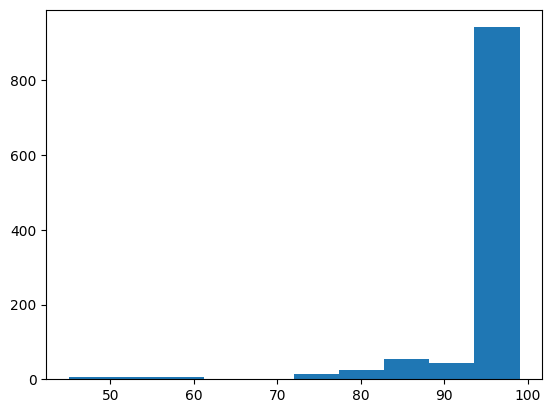

In [27]:
# analysis and validation of fuzzy search results
similarity_scores_village_master_list = pd.Series([v[1] for v in v_with_more_than_two_desc_term_but_no_match["fuzzy_search_result"]])
plt.hist(similarity_scores_village_master_list)
plt.show()

In [28]:
similarity_scores_village_master_list.describe()

count    1098.000000
mean       95.457195
std         7.002180
min        45.000000
25%        96.000000
50%        98.000000
75%        99.000000
max        99.000000
dtype: float64

#### Correcting wrongly inputted patient's origin with only one or two descriptive term
A fuzzy search is applied on the villages in the catchment area of the hf (= area within 5km radius of hf) where the consultation was held.

In [29]:
# import list with correct villages descriptions of each hf
village_correction_by_hf_catchment_dict = pd.read_excel("data/rwanda/village/Village_correction_by_HF_catchment.xlsx", sheet_name=None) # NOTE file provided by domain experts
village_by_hf_catchment = pd.concat([v.assign(hf=k) for k, v in village_correction_by_hf_catchment_dict.items()], ignore_index=True)

# only keep villages in districts rusizi and nyamasheke as these are the only considered districts of the current study (according to domain expert)
village_by_hf_catchment = village_by_hf_catchment.loc[(village_by_hf_catchment["District"] == "Rusizi") | (village_by_hf_catchment["District"] == "Nyamasheke")]

In [30]:
# normalise hf column: remove underscore and numbers
village_by_hf_catchment["hf"] =  village_by_hf_catchment["hf"].str.replace(r"[\d_]", "")

In [31]:
# normalise: lower case (esepcially important for village, cell, sector, district)
village_by_hf_catchment = village_by_hf_catchment.applymap(lambda s: s.lower() if type(s) == str else s)

In [32]:
# create one string for the village description
# TODO: think about deleting since it has become obsolet. we match based on fuzzy search result on village value and not on willage_one_Word
village_by_hf_catchment["village_one_word"] = village_by_hf_catchment["Village"] + village_by_hf_catchment["Cell"] + village_by_hf_catchment["Sector"] + village_by_hf_catchment["District"]

In [33]:
# get consultations with wrongly inputted patient's origin since they only got one descriptive term
v_with_one_or_two_desc_term_and_no_match = v[( (v["count_desc_values"] == 1) | (v["count_desc_values"] == 2) ) & v["Village_Name"].isna()]
v_with_one_or_two_desc_term_and_no_match[['count_desc_values', 'village_one_word', 'Village_Name', 'Cell_Name', 'Sector_Name', 'District_Name']]

count_desc_values village_one_word Village_Name Cell_Name Sector_Name  \
33                     1        nyamagana          NaN       NaN         NaN   
36                     1         kabumbwe          NaN       NaN         NaN   
46                     1        rwinkwavu          NaN       NaN         NaN   
59                     2         mubugaka          NaN       NaN         NaN   
98                     1         kabageni          NaN       NaN         NaN   
...                  ...              ...          ...       ...         ...   
47968                  1           misave          NaN       NaN         NaN   
47980                  1             yove          NaN       NaN         NaN   
47999                  1          kankuba          NaN       NaN         NaN   
48020                  1            mpoga          NaN       NaN         NaN   
48034                  1           nakoko          NaN       NaN         NaN   

      District_Name  
33              NaN  
36              NaN  
46              NaN  
59              NaN  
98              NaN  
...             ...  
47968           NaN  
47980           NaN  
47999           NaN  
48020           NaN  
48034           NaN  

[634 rows x 6 columns]

In [34]:
# normalise column "health_facility_name": remove whitespaces, RW, CS and text in brackets as well as lowecase final textd
v_with_one_or_two_desc_term_and_no_match["health_facility_name"] = [hf.split(" ")[1].lower() for hf in v_with_one_or_two_desc_term_and_no_match["health_facility_name"]]

In [35]:
# perform fuzzy search to find proper village description from the list of villages that are 5km away from the hf
def fuzzy_search_in_catchment_area(village, hf):
    if not (hf in village_by_hf_catchment["hf"].unique()):
        return "hf not in list"
    villages_in_catchment_area = village_by_hf_catchment[village_by_hf_catchment["hf"] == hf]
    closeness_score = [fuzz.ratio(village, v) for v in villages_in_catchment_area[ "Village"]]
    max_value = max(closeness_score)
    max_index = closeness_score.index(max_value)
    best_match = villages_in_catchment_area.iloc[max_index].values
    return (max_index, max_value, best_match)

In [36]:
v_with_one_or_two_desc_term_and_no_match["fuzzy_search_result"] = v_with_one_or_two_desc_term_and_no_match.apply(lambda row: fuzzy_search_in_catchment_area(row.village_one_word, row.health_facility_name), axis=1)

In [37]:
# making out of fuzzy_search_result column multiple columns
v_with_one_or_two_desc_term_and_no_match[['index_best_match_in_ref_list', 'similarity_score', "best_match"]] = v_with_one_or_two_desc_term_and_no_match['fuzzy_search_result'].apply(lambda x: pd.Series(x))
v_with_one_or_two_desc_term_and_no_match[['best_match_village', 'best_match_cell', "best_match_sector", "best_match_district", "hf", "village_one_word"]] = v_with_one_or_two_desc_term_and_no_match['best_match'].apply(lambda x: pd.Series(x))

In [38]:
# remove consultations where patient's origin can not be found in the given hf catchment area
v_not_represented_in_hf_catchment_area_list = v_with_one_or_two_desc_term_and_no_match[~v_with_one_or_two_desc_term_and_no_match["similarity_score"].isna()]
v_not_represented_in_hf_catchment_area_list 

print(v_not_represented_in_hf_catchment_area_list.shape[0], "of", v_with_one_or_two_desc_term_and_no_match.shape[0],"consultations could not be found.")

618 of 634 consultations could not be found.


In [39]:
# viewing fuzzy search result 
# NOTE: the order of the best match of the fuzzy search result is Village, Cell, Sector, District	
v_with_one_or_two_desc_term_and_no_match[["BD9 - Village (Umudugudu) - 8062", "fuzzy_search_result"]]

BD9 - Village (Umudugudu) - 8062  \
33                           nyamagana   
36                            kabumbwe   
46                           rwinkwavu   
59                           mubuga,ka   
98                            kabageni   
...                                ...   
47968                           misave   
47980                             yove   
47999                          kankuba   
48020                            mpoga   
48034                           nakoko   

                                     fuzzy_search_result  
33     (73, 100, [nyamagana, kabuye, nyakarenzo, rusi...  
36     (61, 100, [kabumbwe, gatare, nyakarenzo, rusiz...  
46     (28, 100, [rwinkwavu, turambi, giheke, rusizi,...  
59     (7, 86, [mubuga, kacyuma, gashonga, rusizi, mi...  
98     (94, 100, [kabageni, miko, mururu, rusizi, gih...  
...                                                  ...  
47968  (18, 100, [misave, rusayo, gashonga, rusizi, m...  
47980  (7, 100, [yove, mutongo, cyato, nyamasheke, yo...  
47999  (46, 100, [kankuba, mashesha, gitambi, rusizi,...  
48020  (83, 100, [mpoga, kamanu, nyakabuye, rusizi, m...  
48034  (20, 83, [makoko, mubumbano, kagano, nyamashek...  

[634 rows x 2 columns]

In [40]:
# analysis and validation of fuzzy search results
similarity_scores_hf_catchment_area_list = pd.Series([v[1] for v in v_with_one_or_two_desc_term_and_no_match["fuzzy_search_result"]])
similarity_scores_hf_catchment_area_list = similarity_scores_hf_catchment_area_list.replace("f", np.nan)

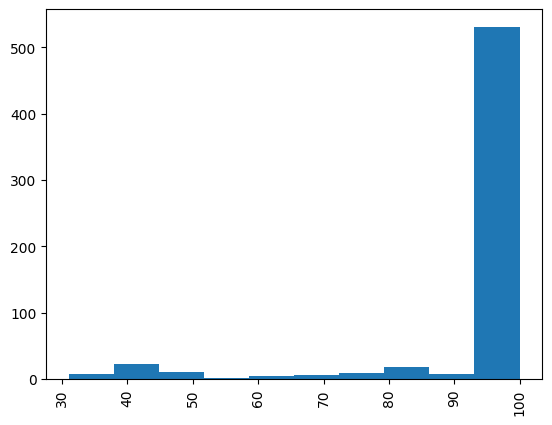

In [41]:
plt.hist(similarity_scores_hf_catchment_area_list)
plt.xticks(rotation=90)
plt.show()


In [42]:
similarity_scores_hf_catchment_area_list.describe()

count    618.000000
mean      94.449838
std       15.529495
min       31.000000
25%      100.000000
50%      100.000000
75%      100.000000
max      100.000000
dtype: float64

In [43]:
# export fuzzy search results based on master list as excel for domain experts
villages_cleaned_by_master_list_fuzzy_search =  v_with_more_than_two_desc_term_but_no_match[["BD9 - Village (Umudugudu) - 8062", "fuzzy_search_result"]]
villages_cleaned_by_master_list_fuzzy_search[['index_master_list', 'similarity_score', "best_match"]] = villages_cleaned_by_master_list_fuzzy_search['fuzzy_search_result'].apply(lambda x: pd.Series(x))
villages_cleaned_by_master_list_fuzzy_search[['best_match_district', 'best_match_sector', "best_match_cell", "best_match_village", "village_one_word"]] = villages_cleaned_by_master_list_fuzzy_search['best_match'].apply(lambda x: pd.Series(x))
villages_cleaned_by_master_list_fuzzy_search[["original_version_village", "original_version_cell", 'original_version_sector', 'original_version_district', "original_version_wrong_fifth_description_term"]] = villages_cleaned_by_master_list_fuzzy_search["BD9 - Village (Umudugudu) - 8062"].str.split(',', expand=True)
villages_cleaned_by_master_list_fuzzy_search["village_name_original_version_matches_catchment_area_list"] = villages_cleaned_by_master_list_fuzzy_search["original_version_village"] == villages_cleaned_by_master_list_fuzzy_search["best_match_village"]
villages_cleaned_by_master_list_fuzzy_search[["original_version_district", "original_version_sector", 'original_version_cell', 'original_version_village', "original_version_wrong_fifth_description_term", 'best_match_district', 'best_match_sector', "best_match_cell", "best_match_village", "similarity_score", "village_name_original_version_matches_catchment_area_list"]].to_excel("data/rwanda/cleaning-villages-results/villages_cleaned_by_master_list_fuzzy_search.xlsx")

In [44]:
# export fuzzy search results based on catchment area list as excel for domain experts
villages_cleaned_by_hf_catchment_area_fuzzy_search =  v_with_one_or_two_desc_term_and_no_match[["BD9 - Village (Umudugudu) - 8062", "fuzzy_search_result"]]
villages_cleaned_by_hf_catchment_area_fuzzy_search[['index_catchment_area_list', 'similarity_score', "best_match"]] = villages_cleaned_by_hf_catchment_area_fuzzy_search['fuzzy_search_result'].apply(lambda x: pd.Series(x))
villages_cleaned_by_hf_catchment_area_fuzzy_search[['best_match_village', 'best_match_cell', "best_match_sector", "best_match_district", "hf", "village_one_word"]] = villages_cleaned_by_hf_catchment_area_fuzzy_search['best_match'].apply(lambda x: pd.Series(x))
villages_cleaned_by_hf_catchment_area_fuzzy_search["original_version_village"] = villages_cleaned_by_hf_catchment_area_fuzzy_search["BD9 - Village (Umudugudu) - 8062"]
villages_cleaned_by_hf_catchment_area_fuzzy_search["village_name_original_version_matches_catchment_area_list"] = villages_cleaned_by_hf_catchment_area_fuzzy_search["original_version_village"] == villages_cleaned_by_hf_catchment_area_fuzzy_search["best_match_village"]
villages_cleaned_by_hf_catchment_area_fuzzy_search[['original_version_village', 'best_match_district', 'best_match_sector', "best_match_cell", "best_match_village", "similarity_score", "village_name_original_version_matches_catchment_area_list"]].to_excel("data/rwanda/cleaning-villages-results/villages_cleaned_by_hf_catchment_area_fuzzy_search.xlsx")

In [45]:
# validate fuzzy search results based on hf catchment area list
print(sum(villages_cleaned_by_hf_catchment_area_fuzzy_search["village_name_original_version_matches_catchment_area_list"]), "fuzzy search results with the hf catchment area list have a matching village name value. This is", sum(villages_cleaned_by_hf_catchment_area_fuzzy_search["village_name_original_version_matches_catchment_area_list"])/villages_cleaned_by_hf_catchment_area_fuzzy_search["village_name_original_version_matches_catchment_area_list"].shape[0]*100,"%","of all results.")

525 fuzzy search results with the hf catchment area list have a matching village name value. This is 82.80757097791798 % of all results.


In [46]:
# to verify that some inputted villages have empty rows in df: village_by_hf_catchment (the reason is that their hf is not in the hf_catchment_area_list)
print(village_by_hf_catchment[village_by_hf_catchment["Village"] == "kivog"] )
v_with_one_or_two_desc_term_and_no_match.loc[v_with_one_or_two_desc_term_and_no_match["BD9 - Village (Umudugudu) - 8062"]== "kivog", ["BD9 - Village (Umudugudu) - 8062", "health_facility_name", "fuzzy_search_result"]]

Empty DataFrame
Columns: [Village, Cell, Sector, District, hf, village_one_word]
Index: []


BD9 - Village (Umudugudu) - 8062 health_facility_name fuzzy_search_result
1959                            kivog                 mont      hf not in list

#### Constructing the final data set with cleaned patient's origin column

In [47]:
v_with_correct_village_desc["fuzzy_search_result"] = np.nan
rw_data_with_cleaned_village = pd.concat([v_with_correct_village_desc, v_with_one_or_two_desc_term_and_no_match, v_with_more_than_two_desc_term_but_no_match])

#### Drop consultations with bad fuzzy search results
With consent of domain experts, consultations with bad fuzzy search results will be dropped based on an arbitrarily chosen similarity score threshold that can easily be adjusted.

In [48]:
similarity_score_threshold = 90
cleaned_rw_data = rw_data_with_cleaned_village[
    (rw_data_with_cleaned_village['similarity_score'] >= similarity_score_threshold) | 
    (rw_data_with_cleaned_village['similarity_score'].isna() & rw_data_with_cleaned_village['fuzzy_search_result'].isna()) # includes consultations whose patient's origin was immediately found in village master list due to join
]

print(rw_data_with_cleaned_village.shape[0]-cleaned_rw_data.shape[0], 
    "consultations were dropped using a similarity score threshold of", 
    similarity_score_threshold
)
print("This accounts for", 
    (rw_data_with_cleaned_village.shape[0]-cleaned_rw_data.shape[0])/rw_data_with_cleaned_village.shape[0]*100, 
    "%", 
    "of all consultations"
)

221 consultations were dropped using a similarity score threshold of 90
This accounts for 0.45939260398694576 % of all consultations


# Data preparation

### Adding another spatial dimension: the patient's origin

In [49]:
# import shapes of all villages in RW
import shapefile

shape_meta = shapefile.Reader("data/rwanda/village/shapefiles/Village.dbf")
shapeRec = pd.DataFrame(shape_meta.shapeRecords().__geo_interface__["features"])

# extracting the relevant columns
shapeRec[['District', 'Sector', 'Cell', "Village"]] = shapeRec['properties'].apply(lambda x: pd.Series([x['District'], x['Sector'],x['Cell'], x['Name']]))
shapeRec["coordinates"] = shapeRec["geometry"].apply(lambda x: pd.Series([x["coordinates"][0]]))
rw_village_coordinates = shapeRec[['District', 'Sector', 'Cell', "Village", "coordinates"]]
rw_village_coordinates

District  Sector       Cell     Village  \
0      Nyarugenge  Gitega  Akabahizi     Gihanga   
1      Nyarugenge  Gitega  Akabahizi  Iterambere   
2      Nyarugenge  Gitega  Akabahizi       Izuba   
3      Nyarugenge  Gitega  Akabahizi  Nyaburanga   
4      Nyarugenge  Gitega  Akabahizi    Nyenyeri   
...           ...     ...        ...         ...   
14810    Bugesera  Shyara     Rutare      Gaseke   
14811    Bugesera  Shyara     Rutare     Kamweru   
14812    Bugesera  Shyara     Rutare     Ruhanga   
14813    Bugesera  Shyara     Rutare      Rutare   
14814    Bugesera  Shyara     Rutare      Shyara   

                                             coordinates  
0      [(505804.1074000001, 4784697.3946), (505808.87...  
1      [(505725.3504999997, 4785070.964), (505750.761...  
2      [(505689.33939999994, 4785047.2246), (505712.2...  
3      [(506082.3940000003, 4784751.6763), (506066.27...  
4      [(505779.44519999996, 4784753.8181), (505787.7...  
...                                                  ...  
14810  [(500470.19570000004, 4749405.5013999995), (50...  
14811  [(499906.30709999986, 4747938.3901), (499914.7...  
14812  [(498708.4414999997, 4748230.242699999), (4987...  
14813  [(500611.2845999999, 4748742.6085), (500635.35...  
14814  [(499343.4221999999, 4749244.8101), (499382.59...  

[14815 rows x 5 columns]

In [50]:
!pip install pyproj


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
# transformer for converting coordinates in shapefile following projected coordinate system to gps
from pyproj import Transformer

utm_crs = 'PROJCS["TM_Rwanda",GEOGCS["GCS_ITRF_2005",DATUM["D_ITRF_2005",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",5000000.0],PARAMETER["Central_Meridian",30.0],PARAMETER["Scale_Factor",0.9999],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]'
gps_crs = 'EPSG:4326' #gps

transformer = Transformer.from_crs(utm_crs, gps_crs)

# test transformer
x, y = transformer.transform(505804.1074000001, 4784697.3946)
print(x, y)

-1.9473174395361728 30.052174320526692


In [52]:
# transform shapes into gps shapes
rw_village_coordinates["gps_coordinates"] = [[transformer.transform(point[0], point[1]) for point in shape] for shape in rw_village_coordinates["coordinates"]]

In [53]:
# compute gps center of each village's shape
def center_point(coords):
    lats = [coord[1] for coord in coords]
    longs = [coord[0] for coord in coords]
    center_lat = np.mean(lats)
    center_long = np.mean(longs)
    return (center_long, center_lat)

rw_village_coordinates["center_gps"] = [center_point(shape) for shape in rw_village_coordinates["gps_coordinates"]]
rw_village_coordinates[["latitude_village", "longitude_village"]] = rw_village_coordinates["center_gps"].apply(lambda x: pd.Series({"latitude_village": x[0], "longitude_village": x[1]}))

In [54]:
import plotly.express as px
fig = px.scatter_mapbox(rw_village_coordinates, lon="longitude_village", lat="latitude_village", hover_name = "Village",
                                hover_data = ["Village"],
                                center=dict(lon=30, lat=-1.9), zoom=7,
                                mapbox_style="stamen-terrain") #animation_frame='Date' for temporal dimension
fig.show()

In [55]:
# filter for villages in madagaskar and store them as csv so that domain experts can crosscheck the error
rw_village_coordinates[rw_village_coordinates["longitude_village"] >= 40].to_csv("data/rw-villages-in-madagaskar.csv")

In [56]:
# normalise string columns (lowercase) and create one word of the village description
rw_village_coordinates = rw_village_coordinates.applymap(lambda s: s.lower() if type(s) == str else s)
rw_village_coordinates

District  Sector       Cell     Village  \
0      nyarugenge  gitega  akabahizi     gihanga   
1      nyarugenge  gitega  akabahizi  iterambere   
2      nyarugenge  gitega  akabahizi       izuba   
3      nyarugenge  gitega  akabahizi  nyaburanga   
4      nyarugenge  gitega  akabahizi    nyenyeri   
...           ...     ...        ...         ...   
14810    bugesera  shyara     rutare      gaseke   
14811    bugesera  shyara     rutare     kamweru   
14812    bugesera  shyara     rutare     ruhanga   
14813    bugesera  shyara     rutare      rutare   
14814    bugesera  shyara     rutare      shyara   

                                             coordinates  \
0      [(505804.1074000001, 4784697.3946), (505808.87...   
1      [(505725.3504999997, 4785070.964), (505750.761...   
2      [(505689.33939999994, 4785047.2246), (505712.2...   
3      [(506082.3940000003, 4784751.6763), (506066.27...   
4      [(505779.44519999996, 4784753.8181), (505787.7...   
...                                                  ...   
14810  [(500470.19570000004, 4749405.5013999995), (50...   
14811  [(499906.30709999986, 4747938.3901), (499914.7...   
14812  [(498708.4414999997, 4748230.242699999), (4987...   
14813  [(500611.2845999999, 4748742.6085), (500635.35...   
14814  [(499343.4221999999, 4749244.8101), (499382.59...   

                                         gps_coordinates  \
0      [(-1.9473174395361728, 30.052174320526692), (-...   
1      [(-1.9439387164006545, 30.051466256263986), (-...   
2      [(-1.9441534370853488, 30.051142552237927), (-...   
3      [(-1.9468264094804004, 30.054675879698678), (-...   
4      [(-1.9468071246056908, 30.051952611351428), (-...   
...                                                  ...   
14810  [(-2.266514935034641, 30.004227547447556), (-2...   
14811  [(-2.2797841651048216, 29.999157595874365), (-...   
14812  [(-2.2771444704109625, 29.988387463507063), (-...   
14813  [(-2.272510436926198, 30.00549610575808), (-2....   
14814  [(-2.2679682947008137, 29.994096678108583), (-...   

                                      center_gps  latitude_village  \
0       (-1.9481017833761631, 30.05229680936519)         -1.948102   
1      (-1.9456671128296834, 30.052606152215212)         -1.945667   
2      (-1.9447035908774273, 30.050792203288733)         -1.944704   
3       (-1.947536650856193, 30.053989256753532)         -1.947537   
4      (-1.9473031147058788, 30.051666486846646)         -1.947303   
...                                          ...               ...   
14810   (-2.2698722752970775, 30.00040273164282)         -2.269872   
14811   (-2.2836209316375453, 30.00400133954392)         -2.283621   
14812   (-2.2815142038693947, 29.98870886971765)         -2.281514   
14813   (-2.277080507620433, 30.006476106560523)         -2.277081   
14814  (-2.2746881515899693, 29.996003996110282)         -2.274688   

       longitude_village  
0              30.052297  
1              30.052606  
2              30.050792  
3              30.053989  
4              30.051666  
...                  ...  
14810          30.000403  
14811          30.004001  
14812          29.988709  
14813          30.006476  
14814          29.996004  

[14815 rows x 9 columns]

In [57]:
# add coordinates to final df
# NOTE: merging the "rw_village_coordinates" needs to be 
# differentiated for consultations whose patient's origin 
# was correctly inputted and not. Both requires different join keys
prepared_cleaned_rw_data = pd.concat([
    cleaned_rw_data.merge(
        rw_village_coordinates, 
        left_on=['District_Name', 'Sector_Name', 'Cell_Name', 'Village_Name'], 
        right_on=['District', 'Sector', 'Cell', 'Village']
    ),
    cleaned_rw_data.merge(
        rw_village_coordinates, 
        left_on=['best_match_district', 'best_match_sector', 'best_match_cell', 'best_match_village'], 
        right_on=['District', 'Sector', 'Cell', 'Village']
    )
])

### Add fever as a general symptom
The CDSS differentiates fever when the patient is infant (= "CC33 - Fever or convulsions or lethargy - 7391") or not (= "CC32 - Fever - 8081"). In this section a new column "fever" will be engineered from the two fever columns based on XOR.

In [58]:
# add general fever column
prepared_cleaned_rw_data["fever"] = prepared_cleaned_rw_data["CC33 - Fever or convulsions or lethargy - 7391"] + prepared_cleaned_rw_data["CC32 - Fever - 8081"]
prepared_cleaned_rw_data["fever"] = [0 if fever == "NoNo" else 1 for fever in prepared_cleaned_rw_data["fever"]]

## Suggested data preparation

In [59]:
# add "medical_case_consultation_date_day" column which gives just the data of the consultation day (no time)
prepared_cleaned_rw_data["medical_case_consultation_date_day"] = prepared_cleaned_rw_data["medical_case_consultation_date"].str.slice(0,10)

### Preparing data on patients' age
According to the domain experts there are several variables for age and some of them have errors. To correct:
- If ‘medical_case_birthdate’ and ‘BD5 – Age in days’ differ by 1-2 days, use ‘BD5 – Age in days’
- If ‘medical_case_birthdate’ and ‘BD5 – Age in days’ differ by 3 days or more, use ‘medical_case_birthdate’
- If ‘medical_case_birthdate’ and ‘BD5 – Age in days’ are both blank, use ‘patient_birthdate’
- If ‘medical_case_birthdate’ is blank and ‘BD5 – Age in days’ is not blank, use ‘BD5 – Age in days’
- If ‘BD5 – Age in days’ is blank and ‘medical_case_birthdate’ is not blank, use ‘medical_case_birthdate’

In [60]:
#prepared_cleaned_rw_data[['BD5 - Age in days', 'medical_case_birthdate']]

In [61]:
# add "patient_age" column which gives the age of the patient at the time of consultation in years instead of days like in patient_birthdate
prepared_cleaned_rw_data["patient_age"] = (prepared_cleaned_rw_data["patient_birthdate"] / 365) // 1

# Create the correct age column
"""prepared_cleaned_rw_data['patient_age'] = np.where(
    (~prepared_cleaned_rw_data['medical_case_birthdate'].isna()) & (~prepared_cleaned_rw_data['BD5 - Age in days'].isna()),
    np.where(
        abs(pd.to_datetime(prepared_cleaned_rw_data['medical_case_birthdate']) - pd.to_datetime(prepared_cleaned_rw_data['BD5 - Age in days'], unit='D')).dt.days <= 2,
        prepared_cleaned_rw_data['BD5 - Age in days'],
        prepared_cleaned_rw_data['medical_case_birthdate']
    ),
    np.where(
        prepared_cleaned_rw_data['medical_case_birthdate'].isna(),
        prepared_cleaned_rw_data['BD5 - Age in days'],
        prepared_cleaned_rw_data['medical_case_birthdate']
    )
)

prepared_cleaned_rw_data["patient_age"]"""

'prepared_cleaned_rw_data[\'patient_age\'] = np.where(\n    (~prepared_cleaned_rw_data[\'medical_case_birthdate\'].isna()) & (~prepared_cleaned_rw_data[\'BD5 - Age in days\'].isna()),\n    np.where(\n        abs(pd.to_datetime(prepared_cleaned_rw_data[\'medical_case_birthdate\']) - pd.to_datetime(prepared_cleaned_rw_data[\'BD5 - Age in days\'], unit=\'D\')).dt.days <= 2,\n        prepared_cleaned_rw_data[\'BD5 - Age in days\'],\n        prepared_cleaned_rw_data[\'medical_case_birthdate\']\n    ),\n    np.where(\n        prepared_cleaned_rw_data[\'medical_case_birthdate\'].isna(),\n        prepared_cleaned_rw_data[\'BD5 - Age in days\'],\n        prepared_cleaned_rw_data[\'medical_case_birthdate\']\n    )\n)\n\nprepared_cleaned_rw_data["patient_age"]'

### Dropping consultations whose gender is NAN

In [62]:
# drop rows with NAN in patient_gender
print("amount of data before dropping rows with NAN in patient_gender:", prepared_cleaned_rw_data.shape[0])
prepared_cleaned_rw_data = prepared_cleaned_rw_data[prepared_cleaned_rw_data["patient_gender"].notna()]
print("amount of data after dropping rows with NAN in patient_gender:", prepared_cleaned_rw_data.shape[0])

amount of data before dropping rows with NAN in patient_gender: 47886
amount of data after dropping rows with NAN in patient_gender: 47806


# Storing cleaned and prepared consultation data from RW

In [63]:
prepared_cleaned_rw_data.to_pickle("data/rw-cleaned-prepared-dynamic-data-phase1.pickle")

In [64]:
rw_village_coordinates.to_pickle("data/rw-village-coordinates.pickle")

# Conclusion
In the course of this notebook's cleaning and preparing of CDSS data from RW, the following actions led to droping consultations:

- during the import, 1 consultation (= line 9087 of the raw data) was dropped since it was wrongly formated so that the import recognised more columns in this row as usual. 
- TODO